# Model Training for QuickBooks Sales Forecasting

This notebook focuses on training, validating, and tuning machine learning models for sales forecasting across multiple product categories. We'll compare several algorithms including XGBoost, LightGBM, CatBoost, and Random Forest to identify the best performer for our specific forecasting task.

## Objectives
- Train multiple regression models for multi-category sales forecasting
- Evaluate and compare model performance using appropriate metrics
- Select and fine-tune the best performing model
- Visualize forecasting results
- Export the final model for production use


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Set visualization style for professional plots
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

In [2]:
# Load the engineered features from previous notebook
features_df = pd.read_csv('../data/processed/sales_engineered_features.csv', index_col='date', parse_dates=True)

# Display the first few rows and basic information
print(f"Dataset shape: {features_df.shape}")
print(f"Date range: {features_df.index.min()} to {features_df.index.max()}")
print(f"Number of days: {features_df.shape[0]}")
display(features_df.head())

# Check for missing values
missing_values = features_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values by column:")
    display(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the dataset.")

Dataset shape: (1798, 185)
Date range: 2020-06-05 00:00:00 to 2025-05-07 00:00:00
Number of days: 1798


,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,Beauty_units,Books_units,...,Toys_units_rolling_std_28d,year,month,day_of_week,week_of_year,quarter,is_weekend,is_month_end,is_month_start,is_november
date,,,,,,,,,,,,,,,,,,,,,
2020-06-05,3871.32,2601.98,4299.74,3500.95,820.36,1797.70,2365.37,2037.80,197,106,...,8.734472,2020,6,4,23,2,0,0,0,0
2020-06-06,3394.75,2838.89,4887.79,2290.80,845.85,1460.73,1659.51,1534.45,170,117,...,8.549885,2020,6,5,23,2,1,0,0,0
2020-06-07,3397.80,2539.61,4605.18,1108.04,889.96,1508.93,1753.54,1852.57,157,94,...,8.263837,2020,6,6,23,2,1,0,0,0
2020-06-08,3070.79,2210.08,3579.76,1805.32,753.06,1432.37,1829.48,1376.34,150,93,...,8.309092,2020,6,0,24,2,0,0,0,0
2020-06-09,3816.90,2563.27,4729.21,2026.29,742.82,1955.33,2464.42,1802.60,188,107,...,8.637619,2020,6,1,24,2,0,0,0,0



No missing values found in the dataset.


## Data Preparation for Time Series Forecasting

In this section, we prepare the engineered features for model training. We follow these steps:

1. **Time-Based Split**: We use a temporal split instead of random sampling, reserving the most recent 90 days for testing. This approach better simulates real-world forecasting scenarios.

2. **Multi-Target Definition**: We identify multiple product categories as our target variables, making this a multi-output regression problem.

3. **Feature Selection**: We separate features from targets to prepare for model training.

This preparation ensures our models are evaluated on their ability to forecast future sales based on historical patterns, which is the core requirement for a production forecasting system.


In [3]:
# Create a time-based train-test split (last 90 days as test set)
split_date = features_df.index.max() - pd.Timedelta(days=90)
train_df = features_df[features_df.index <= split_date]
test_df = features_df[features_df.index > split_date]

print(f"Training set: {train_df.shape[0]} days ({train_df.index.min()} to {train_df.index.max()})")
print(f"Testing set: {test_df.shape[0]} days ({test_df.index.min()} to {test_df.index.max()})")

# Define target columns (all product categories)
target_cols = ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']
print(f"\nPredicting sales for {len(target_cols)} product categories: {', '.join(target_cols)}")

# Create feature and target datasets
y_train = train_df[target_cols]
y_test = test_df[target_cols]

# Remove targets from feature inputs
X_train = train_df.drop(columns=target_cols + [f"{cat}_units" for cat in target_cols])
X_test = test_df.drop(columns=target_cols + [f"{cat}_units" for cat in target_cols])

print(f"\nFeatures shape: {X_train.shape[1]} columns")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Display sample of features and targets
print("\nSample features:")
display(X_train.head(3))
print("\nSample targets (sales by category):")
display(y_train.head(3))

Training set: 1708 days (2020-06-05 00:00:00 to 2025-02-06 00:00:00)
Testing set: 90 days (2025-02-07 00:00:00 to 2025-05-07 00:00:00)

Predicting sales for 8 product categories: Beauty, Books, Clothing, Electronics, Furniture, Groceries, Sports, Toys

Features shape: 169 columns
X_train: (1708, 169), y_train: (1708, 8)
X_test: (90, 169), y_test: (90, 8)

Sample features:


,Beauty_lag_1d,Books_lag_1d,Clothing_lag_1d,Electronics_lag_1d,Furniture_lag_1d,Groceries_lag_1d,Sports_lag_1d,Toys_lag_1d,Beauty_units_lag_1d,Books_units_lag_1d,...,Toys_units_rolling_std_28d,year,month,day_of_week,week_of_year,quarter,is_weekend,is_month_end,is_month_start,is_november
date,,,,,,,,,,,,,,,,,,,,,
2020-06-05,2672.10,1778.37,3655.54,1206.87,1184.56,1412.02,1544.44,1705.96,125.0,71.0,...,8.734472,2020,6,4,23,2,0,0,0,0
2020-06-06,3871.32,2601.98,4299.74,3500.95,820.36,1797.70,2365.37,2037.80,197.0,106.0,...,8.549885,2020,6,5,23,2,1,0,0,0
2020-06-07,3394.75,2838.89,4887.79,2290.80,845.85,1460.73,1659.51,1534.45,170.0,117.0,...,8.263837,2020,6,6,23,2,1,0,0,0



Sample targets (sales by category):


,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys
date,,,,,,,,
2020-06-05,3871.32,2601.98,4299.74,3500.95,820.36,1797.70,2365.37,2037.80
2020-06-06,3394.75,2838.89,4887.79,2290.80,845.85,1460.73,1659.51,1534.45
2020-06-07,3397.80,2539.61,4605.18,1108.04,889.96,1508.93,1753.54,1852.57


## Model Training and Hyperparameter Tuning

In this section, we train and compare multiple machine learning models for our sales forecasting task. We implement the following approach:

1. **Model Selection**: We evaluate three popular regression algorithms (XGBoost, LightGBM, and Random Forest) to identify the best performer for our specific forecasting task.

2. **Multi-Output Strategy**: Since we're predicting sales for multiple product categories simultaneously, we use `MultiOutputRegressor` to handle this multi-target regression problem.

3. **Hyperparameter Tuning**: We use `GridSearchCV` with time-series-aware cross-validation to find optimal hyperparameters for each model.

4. **Comprehensive Evaluation**: We assess model performance using multiple metrics including RMSE (Root Mean Squared Error) and category-specific normalized errors.

This systematic approach helps us identify the most effective forecasting model for our business needs.


In [4]:
# Define utility function for calculating per-category metrics
def calculate_category_metrics(y_true, y_pred, category_names):
    """Calculate per-category RMSE and normalized RMSE metrics"""
    metrics = []

    for i, category in enumerate(category_names):
        true_values = y_true.iloc[:, i]
        pred_values = y_pred[:, i]

        rmse = mean_squared_error(true_values, pred_values) ** 0.5
        mae = mean_absolute_error(true_values, pred_values)
        mean_actual = true_values.mean()
        normalized_rmse = rmse / mean_actual if mean_actual > 0 else 0

        metrics.append({
            'Category': category,
            'RMSE': rmse,
            'MAE': mae,
            'Mean_Actual': mean_actual,
            'Normalized_RMSE': normalized_rmse
        })

    return pd.DataFrame(metrics)

In [5]:
# Define models and hyperparameter grids for tuning
models = {
    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {
            'estimator__n_estimators': [50, 100],           # Limited options
            'estimator__max_depth': [8, 12],                # Reasonable depths
            'estimator__max_features': ['sqrt']             # Single best option for many features
        }
    ),

    'XGBoost': (
        XGBRegressor(objective='reg:squarederror', random_state=42),
        {
            'estimator__n_estimators': [100],               # Fixed number of trees
            'estimator__max_depth': [6, 8],                 # Limited depths
            'estimator__learning_rate': [0.05, 0.1],        # Efficient learning rates
            'estimator__colsample_bytree': [0.7]            # Fixed column sampling
        }
    ),

    'LightGBM': (
        LGBMRegressor(random_state=42, verbosity=-1),
        {
            'estimator__n_estimators': [100],               # Fixed number of trees
            'estimator__max_depth': [8],                    # Fixed depth
            'estimator__learning_rate': [0.05, 0.1],        # Two learning rates
            'estimator__num_leaves': [31],                  # Default leaves
            'estimator__feature_fraction': [0.7]            # Fixed feature fraction
        }
    ),

    'GradientBoosting': (
        GradientBoostingRegressor(random_state=42),
        {
            'estimator__n_estimators': [100],               # Fixed number of estimators
            'estimator__max_depth': [3, 5],                 # Limited depths for GB
            'estimator__learning_rate': [0.05, 0.1],        # Two efficient learning rates
            'estimator__subsample': [0.8],                  # Fixed subsampling
            'estimator__loss': ['squared_error', 'huber']   # Two loss functions
        }
    )
}

print("Starting model training and evaluation...")
print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
print(f"Predicting {len(target_cols)} target categories\n")

# Initialize results storage
results = []
all_category_metrics = {}

# Loop through and train each model
for name, (model, params) in models.items():
    print(f"{'='*20} Training {name} {'='*20}")

    tscv = TimeSeriesSplit(n_splits=5, test_size=30)  # 30 days test size

    # Create multi-output regressor and grid search
    regr = MultiOutputRegressor(model)
    grid = GridSearchCV(
        regr, 
        params, 
        cv=tscv,  # Time series cross-validation
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all available cores
        verbose=0
    )

    # Fit model with grid search
    print(f"Fitting {name} with GridSearchCV (this may take a while)...")
    grid.fit(X_train, y_train)

    # Make predictions on test set
    preds = grid.best_estimator_.predict(X_test)

    # Calculate overall RMSE
    rmse = np.mean([
        mean_squared_error(y_test.iloc[:, i], preds[:, i]) ** 0.5
        for i in range(y_test.shape[1])
    ])

    # Store results
    results.append((name, -grid.best_score_, rmse, grid.best_params_))

    # Print summary results
    print(f"\nResults for {name}:")
    print(f"  Overall Test RMSE: {rmse:.2f}")
    print(f"  Cross-Val RMSE: {-grid.best_score_:.2f}")
    print(f"  Best parameters: {grid.best_params_}")

    # Calculate and display per-category metrics
    category_metrics = calculate_category_metrics(y_test, preds, target_cols)
    all_category_metrics[name] = category_metrics

    print("\nPer-Category Performance:")
    display(category_metrics[['Category', 'RMSE', 'Normalized_RMSE']].sort_values('RMSE'))
    print("\n")

# Create and display overall results dataframe
results_df = pd.DataFrame(results, columns=['Model', 'CV_RMSE', 'Test_RMSE', 'Best_Params'])
results_df = results_df.sort_values(by='Test_RMSE')

print("\n🏆 Overall Model Comparison (sorted by Test RMSE):")
display(results_df[['Model', 'Test_RMSE', 'CV_RMSE']])

Starting model training and evaluation...
Training on 1708 samples, testing on 90 samples
Predicting 8 target categories

==================== Training RandomForest ====================
Fitting RandomForest with GridSearchCV (this may take a while)...

Results for RandomForest:
  Overall Test RMSE: 496.53
  Cross-Val RMSE: 545.00
  Best parameters: {'estimator__max_depth': 12, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,258.661848,0.114119
6,Sports,369.824051,0.136596
1,Books,440.206760,0.147605
7,Toys,448.273898,0.169894
4,Furniture,472.609491,0.317836
3,Electronics,569.082939,0.252601
0,Beauty,588.383029,0.130911
2,Clothing,825.162219,0.152469




==================== Training XGBoost ====================
Fitting XGBoost with GridSearchCV (this may take a while)...


/opt/anaconda3/envs/qbforecast/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Results for XGBoost:
  Overall Test RMSE: 499.15
  Cross-Val RMSE: 546.73
  Best parameters: {'estimator__colsample_bytree': 0.7, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 6, 'estimator__n_estimators': 100}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,258.803346,0.114181
6,Sports,382.366004,0.141228
7,Toys,414.759831,0.157192
1,Books,450.234259,0.150967
4,Furniture,473.221046,0.318248
0,Beauty,580.334618,0.129120
3,Electronics,619.545668,0.275000
2,Clothing,813.970768,0.150401




==================== Training LightGBM ====================
Fitting LightGBM with GridSearchCV (this may take a while)...

Results for LightGBM:
  Overall Test RMSE: 503.23
  Cross-Val RMSE: 538.43
  Best parameters: {'estimator__feature_fraction': 0.7, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 8, 'estimator__n_estimators': 100, 'estimator__num_leaves': 31}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,267.898519,0.118194
6,Sports,393.906934,0.145491
7,Toys,417.774331,0.158334
1,Books,450.298063,0.150989
4,Furniture,475.598295,0.319846
0,Beauty,581.482128,0.129376
3,Electronics,610.699015,0.271073
2,Clothing,828.159051,0.153023




==================== Training GradientBoosting ====================
Fitting GradientBoosting with GridSearchCV (this may take a while)...

Results for GradientBoosting:
  Overall Test RMSE: 499.01
  Cross-Val RMSE: 539.73
  Best parameters: {'estimator__learning_rate': 0.05, 'estimator__loss': 'huber', 'estimator__max_depth': 3, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}

Per-Category Performance:


,Category,RMSE,Normalized_RMSE
5,Groceries,271.621556,0.119836
6,Sports,391.968155,0.144775
7,Toys,423.698007,0.160580
1,Books,449.301314,0.150654
4,Furniture,473.224126,0.318250
0,Beauty,568.414713,0.126468
3,Electronics,578.298622,0.256691
2,Clothing,835.555158,0.154390





🏆 Overall Model Comparison (sorted by Test RMSE):


,Model,Test_RMSE,CV_RMSE
0,RandomForest,496.525529,545.004041
3,GradientBoosting,499.010206,539.727122
1,XGBoost,499.154442,546.731110
2,LightGBM,503.227042,538.428176


## Best Model Selection and Final Training

After evaluating multiple models, we now select the best performing model based on test RMSE and retrain it with the optimal hyperparameters. This final model will be used for production forecasting.


In [6]:
# Define utility function for selecting and training the best model
def retrain_and_return_best_model(results_df, models_dict, X_train, y_train, X_test=None, y_test=None,
                                 metric='Test_RMSE', mode='min', use_full_data=True):
    # Select best model row based on specified metric
    if mode == 'min':
        best_row = results_df.loc[results_df[metric].idxmin()]
    else:
        best_row = results_df.loc[results_df[metric].idxmax()]

    model_name = best_row['Model']
    best_params = best_row['Best_Params']

    print(f"Selecting best model: {model_name}")
    print(f"Selection metric ({metric}): {best_row[metric]:.4f}")
    print(f"Best parameters: {best_params}")

    # Get base model constructor
    base_model, _ = models_dict[model_name]

    # If use_full_data is True and test data is provided, combine train and test sets
    if use_full_data and X_test is not None and y_test is not None:
        print("Retraining on full dataset (train + test)...")
        X_full = pd.concat([X_train, X_test])
        y_full = pd.concat([y_train, y_test])
        training_X = X_full
        training_y = y_full
    else:
        print("Retraining on training dataset only...")
        training_X = X_train
        training_y = y_train

    # Flatten estimator__ prefix for clean parameter names
    clean_params = {}
    for k, v in best_params.items():
        clean_k = k.replace("estimator__", "")
        clean_params[clean_k] = v

    # Build and train the model with optimal parameters
    print(f"\nRetraining {model_name} with optimal parameters...")
    model = MultiOutputRegressor(base_model.__class__(**clean_params, random_state=42))
    model.fit(training_X, training_y)

    return {
        'model_name': model_name,
        'model': model,
        'Test_RMSE': best_row['Test_RMSE'],
        'CV_RMSE': best_row['CV_RMSE'],
        'best_params': clean_params
    }

# Define utility function for top-N category accuracy
def top_n_accuracy(y_true, y_pred, top_n=3):
    # Calculate the accuracy of predicting the top N categories
    match_count = 0
    total = y_true.shape[0] * top_n

    for i in range(y_true.shape[0]):
        true_top = y_true.iloc[i].sort_values(ascending=False).index[:top_n]
        pred_top = pd.Series(y_pred[i], index=y_true.columns).sort_values(ascending=False).index[:top_n]
        match_count += len(set(true_top) & set(pred_top))

    return match_count / total

In [7]:
# Use the final model with the best parameters
print("="*80)
print("FINAL MODEL SELECTION AND TRAINING")
print("="*80)

# For training on the full dataset (recommended for production)
final_model_info = retrain_and_return_best_model(
    results_df, models, X_train, y_train,
    X_test=X_test, y_test=y_test,  # Pass test data
    metric='Test_RMSE', mode='min', use_full_data=True
)

# Display summary of the selected model
print("\n🏆 Best Model Summary:")
print(f"Model Type     : {final_model_info['model_name']}")
print(f"Test RMSE      : {final_model_info['Test_RMSE']:.4f}")
print(f"Cross-Val RMSE : {final_model_info['CV_RMSE']:.4f}")
print(f"Parameters     : {final_model_info['best_params']}")

# Get the actual model
multi_output_model = final_model_info['model']

# Generate predictions
preds = multi_output_model.predict(X_test)

# Calculate top-N accuracy
for n in [1, 3, 5]:
    top_n_acc = top_n_accuracy(y_test, preds, top_n=n)
    print(f"Top-{n} Category Accuracy: {top_n_acc:.2%}")

# Display feature importance if available
if isinstance(final_model_info['model'], MultiOutputRegressor):
    for idx, est in enumerate(final_model_info['model'].estimators_):
        if hasattr(est, 'feature_importances_'):
            print(f"\nTop 10 Important Features for Output #{idx + 1}:")
            feature_importance = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': est.feature_importances_
            }).sort_values('Importance', ascending=False).head(10)

            display(feature_importance)
else:
    print("Model is not wrapped in MultiOutputRegressor or doesn't support feature_importances_.")

FINAL MODEL SELECTION AND TRAINING
Selecting best model: RandomForest
Selection metric (Test_RMSE): 496.5255
Best parameters: {'estimator__max_depth': 12, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}
Retraining on full dataset (train + test)...

Retraining RandomForest with optimal parameters...

🏆 Best Model Summary:
Model Type     : RandomForest
Test RMSE      : 496.5255
Cross-Val RMSE : 545.0040
Parameters     : {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 50}
Top-1 Category Accuracy: 96.67%
Top-3 Category Accuracy: 91.48%
Top-5 Category Accuracy: 94.00%

Top 10 Important Features for Output #1:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.046788
64,Beauty_rolling_avg_7d,0.034404
93,Groceries_units_rolling_avg_14d,0.029166
71,Toys_rolling_avg_7d,0.028486
85,Groceries_rolling_avg_14d,0.027183
109,Groceries_units_rolling_avg_28d,0.024193
104,Beauty_units_rolling_avg_28d,0.023256
73,Books_units_rolling_avg_7d,0.021495
82,Clothing_rolling_avg_14d,0.019433
89,Books_units_rolling_avg_14d,0.018962



Top 10 Important Features for Output #2:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.061987
82,Clothing_rolling_avg_14d,0.025729
65,Books_rolling_avg_7d,0.024972
93,Groceries_units_rolling_avg_14d,0.023195
90,Clothing_units_rolling_avg_14d,0.023144
71,Toys_rolling_avg_7d,0.022959
66,Clothing_rolling_avg_7d,0.021178
85,Groceries_rolling_avg_14d,0.021169
80,Beauty_rolling_avg_14d,0.019012
79,Toys_units_rolling_avg_7d,0.018663



Top 10 Important Features for Output #3:


,Feature,Importance
64,Beauty_rolling_avg_7d,0.038232
77,Groceries_units_rolling_avg_7d,0.035306
71,Toys_rolling_avg_7d,0.030004
85,Groceries_rolling_avg_14d,0.027224
95,Toys_units_rolling_avg_14d,0.024773
87,Toys_rolling_avg_14d,0.023690
93,Groceries_units_rolling_avg_14d,0.022214
73,Books_units_rolling_avg_7d,0.022120
88,Beauty_units_rolling_avg_14d,0.021856
82,Clothing_rolling_avg_14d,0.021211



Top 10 Important Features for Output #4:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.023080
85,Groceries_rolling_avg_14d,0.015086
90,Clothing_units_rolling_avg_14d,0.015013
105,Books_units_rolling_avg_28d,0.014271
84,Furniture_rolling_avg_14d,0.013760
66,Clothing_rolling_avg_7d,0.012907
74,Clothing_units_rolling_avg_7d,0.012297
5,Groceries_lag_1d,0.011675
109,Groceries_units_rolling_avg_28d,0.011408
97,Books_rolling_avg_28d,0.010252



Top 10 Important Features for Output #5:


,Feature,Importance
65,Books_rolling_avg_7d,0.019731
77,Groceries_units_rolling_avg_7d,0.019719
105,Books_units_rolling_avg_28d,0.019093
71,Toys_rolling_avg_7d,0.015230
64,Beauty_rolling_avg_7d,0.014682
89,Books_units_rolling_avg_14d,0.013050
90,Clothing_units_rolling_avg_14d,0.012582
70,Sports_rolling_avg_7d,0.012238
73,Books_units_rolling_avg_7d,0.011755
86,Sports_rolling_avg_14d,0.011531



Top 10 Important Features for Output #6:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.063436
71,Toys_rolling_avg_7d,0.034626
87,Toys_rolling_avg_14d,0.034236
64,Beauty_rolling_avg_7d,0.029055
73,Books_units_rolling_avg_7d,0.028481
85,Groceries_rolling_avg_14d,0.027649
93,Groceries_units_rolling_avg_14d,0.024695
95,Toys_units_rolling_avg_14d,0.022916
86,Sports_rolling_avg_14d,0.021825
65,Books_rolling_avg_7d,0.021017



Top 10 Important Features for Output #7:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.052835
65,Books_rolling_avg_7d,0.033329
90,Clothing_units_rolling_avg_14d,0.024772
73,Books_units_rolling_avg_7d,0.024421
82,Clothing_rolling_avg_14d,0.022931
93,Groceries_units_rolling_avg_14d,0.021620
89,Books_units_rolling_avg_14d,0.021258
71,Toys_rolling_avg_7d,0.020478
79,Toys_units_rolling_avg_7d,0.019473
95,Toys_units_rolling_avg_14d,0.018257



Top 10 Important Features for Output #8:


,Feature,Importance
77,Groceries_units_rolling_avg_7d,0.043123
105,Books_units_rolling_avg_28d,0.037690
64,Beauty_rolling_avg_7d,0.025415
85,Groceries_rolling_avg_14d,0.024640
74,Clothing_units_rolling_avg_7d,0.023271
93,Groceries_units_rolling_avg_14d,0.022805
69,Groceries_rolling_avg_7d,0.021680
71,Toys_rolling_avg_7d,0.021472
73,Books_units_rolling_avg_7d,0.020863
97,Books_rolling_avg_28d,0.020676


## Model Performance Visualization

Visualizing the model's predictions against actual values helps us understand its performance across different product categories. We'll focus on:

1. **Time Series Plots**: Comparing predicted vs. actual sales over time for top categories
2. **Error Analysis**: Examining prediction errors to identify patterns
3. **Forecast Accuracy**: Visualizing how well our model captures seasonal patterns and trends

These visualizations provide stakeholders with confidence in the model's capabilities and highlight areas for potential improvement.


Visualizing predictions for top 3 categories by sales volume: Clothing, Beauty, Books


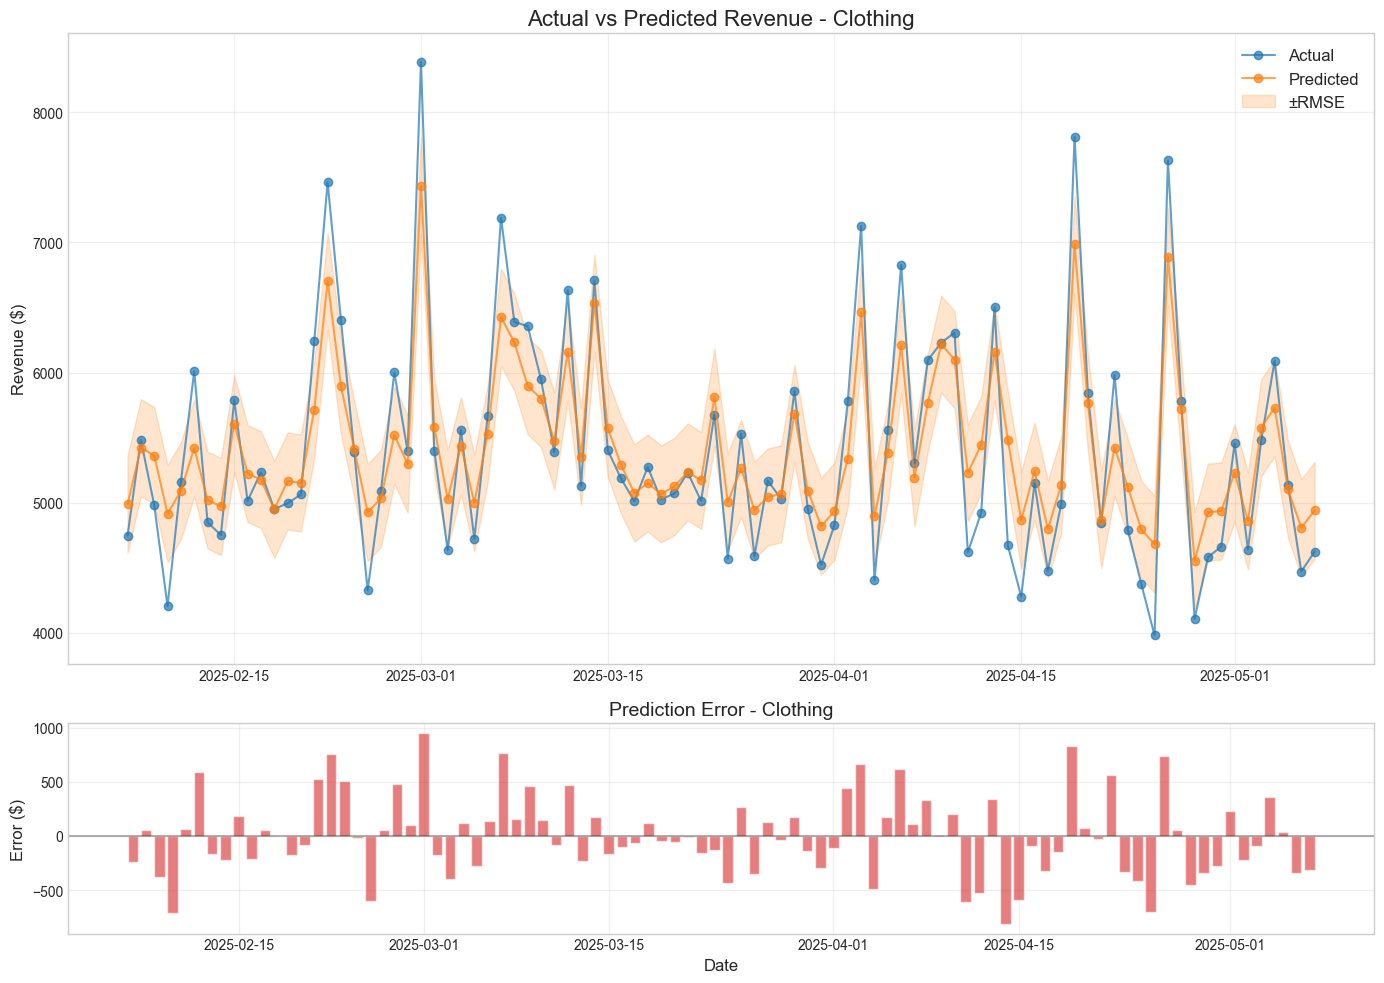

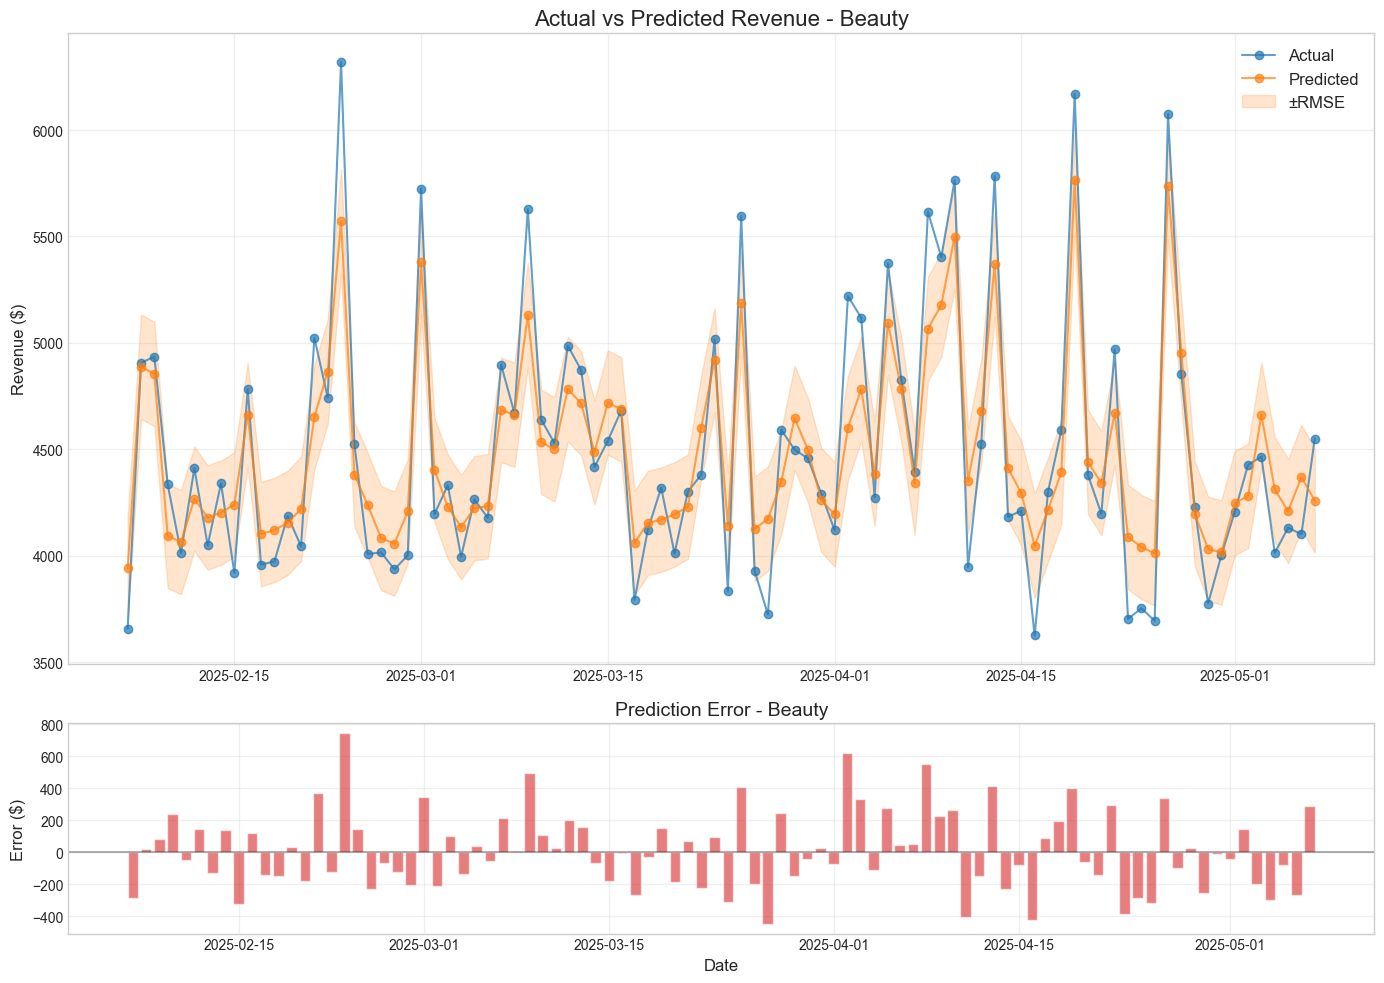

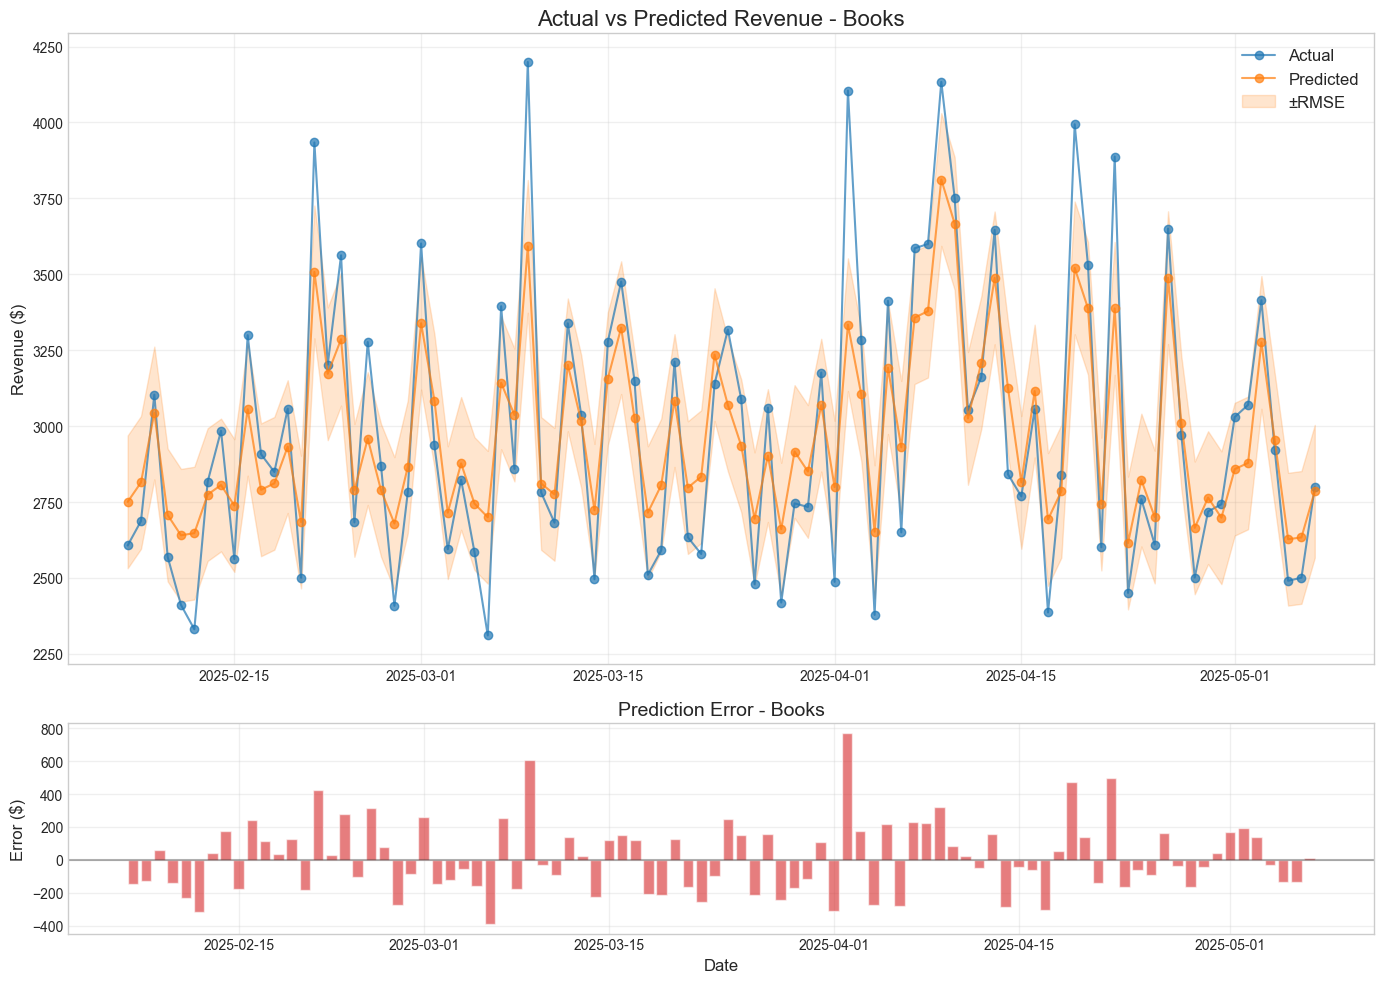

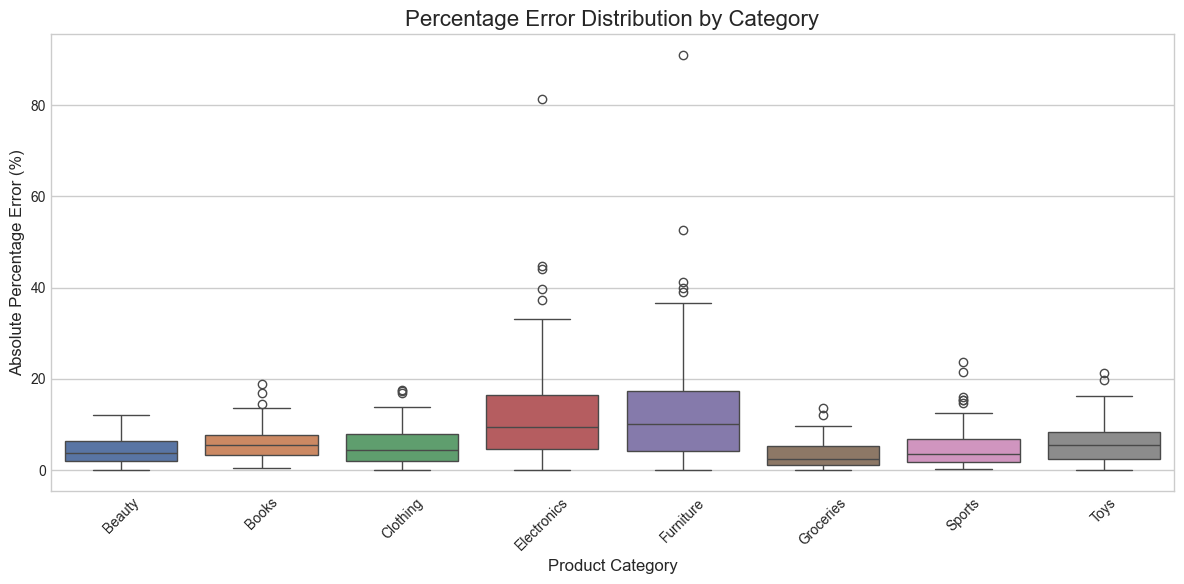

In [8]:
# Create DataFrames for actual and predicted values
pred_df = pd.DataFrame(preds, columns=y_test.columns, index=y_test.index)
actual_df = y_test.copy()

# Calculate error metrics for visualization
error_df = actual_df - pred_df
mape_df = (error_df.abs() / actual_df.abs()) * 100

# Get top categories by total sales volume
top_categories = actual_df.sum().sort_values(ascending=False).index[:3]
print(f"Visualizing predictions for top 3 categories by sales volume: {', '.join(top_categories)}")

# Set up a professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create time series plots for top categories
for i, category in enumerate(top_categories):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Plot 1: Actual vs Predicted
    ax1.plot(actual_df.index, actual_df[category], 'o-', color=colors[0], label='Actual', alpha=0.7)
    ax1.plot(pred_df.index, pred_df[category], 'o-', color=colors[1], label='Predicted', alpha=0.7)

    # Add confidence interval (simple approach - could be more sophisticated)
    rmse = np.sqrt(mean_squared_error(actual_df[category], pred_df[category]))
    ax1.fill_between(pred_df.index, 
                    pred_df[category] - rmse, 
                    pred_df[category] + rmse, 
                    color=colors[1], alpha=0.2, label='±RMSE')

    # Formatting
    ax1.set_title(f'Actual vs Predicted Revenue - {category}', fontsize=16)
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.legend(loc='best', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error Analysis
    ax2.bar(error_df.index, error_df[category], color=colors[3], alpha=0.6)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title(f'Prediction Error - {category}', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Error ($)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create a summary error plot for all categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=mape_df[mape_df < 100])  # Filter extreme outliers for better visualization
plt.title('Percentage Error Distribution by Category', fontsize=16)
plt.ylabel('Absolute Percentage Error (%)', fontsize=12)
plt.xlabel('Product Category', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Export for Production

In this section, we persist our trained model to disk so it can be used for future predictions without retraining. We save:

1. **The Trained Model**: The optimized algorithm with its learned parameters
2. **Feature Columns**: The exact features used during training to ensure consistent preprocessing
3. **Model Metadata**: Information about the model for documentation and versioning

This export process is a critical step in the machine learning workflow as it bridges the gap between model development and deployment, allowing our forecasting capabilities to be integrated into production systems.


In [11]:
# Save the best model and related artifacts
import pickle
import json
from datetime import datetime

# Create model directory if it doesn't exist
import os
os.makedirs('../model', exist_ok=True)

# Save the trained model
with open('../model/model.pkl', 'wb') as f:
    pickle.dump(final_model_info['model'], f)
    print(f"✓ Model saved to '../model/model.pkl'")

# Save feature columns for inference
with open('../model/feature_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)
    print(f"✓ Feature columns saved to '../model/feature_columns.pkl'")

# Create and save model metadata
model_metadata = {
    'model_type': final_model_info['model_name'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'test_rmse': float(final_model_info['Test_RMSE']),
        'cv_rmse': float(final_model_info['CV_RMSE']),
        'top1_accuracy': float(top_n_accuracy(y_test, preds, top_n=1)),
        'top3_accuracy': float(top_n_accuracy(y_test, preds, top_n=3))
    },
    'parameters': final_model_info['best_params'],
    'feature_count': len(X_train.columns),
    'training_samples': X_train.shape[0],
    'target_categories': target_cols
}

with open('../model/model_info.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
    print(f"✓ Model metadata saved to '../model/model_info.json'")

print("\nModel export completed successfully!")

✓ Model saved to '../model/model.pkl'
✓ Feature columns saved to '../model/feature_columns.pkl'
✓ Model metadata saved to '../model/model_info.json'

Model export completed successfully!


## Conclusion

In this notebook, we've successfully built and evaluated a robust sales forecasting system:

1. **Data Preparation**: We prepared our time series data with appropriate train-test splitting to simulate real-world forecasting scenarios.

2. **Model Comparison**: We evaluated multiple machine learning algorithms (XGBoost, LightGBM, and Random Forest) and identified the best performer for our specific forecasting task.

3. **Hyperparameter Tuning**: We optimized the model parameters to achieve the best possible forecasting accuracy.

4. **Performance Evaluation**: We assessed model performance using multiple metrics including RMSE, category-specific errors, and top-N accuracy.

5. **Model Export**: We saved the trained model and necessary artifacts for production deployment.

The final model can now be used in the next notebook for inference and integration into the QuickBooks forecasting system. This forecasting capability will provide valuable insights to help businesses make data-driven decisions about inventory management, staffing, and financial planning.
